<a href="https://colab.research.google.com/gist/Yong-Zhuang/2c3d35b89cb960c04e66e2a967e1a170/dataset-normality-test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Normality and Equal-variance Test
### Test weekly or the full eight weeks of data?
Ideally, we should test for normality and equal variance on each week's data separately for both activated and non-activated groups. This is because the distribution and variance of the data may change from week to week, and analyzing them separately can help to identify any potential differences or trends.

However, if we have limited data and the sample size is small, we may not have enough statistical power to detect differences between the weeks, and in that case, it may be appropriate to analyze the data for each group as a whole (i.e., combining data from all 8 weeks). In this case, we would need to test for normality and equal variance on the combined data set for each group separately.


### Normality Test
Every data will take the following normality tests:
- Shapiro Wilk
- Anderson Darling
- Lilliefors

### Equal-variance Test
- Levene's test

In [ ]:
!pip install statsmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import shapiro, kstest, norm, anderson, chisquare, levene
from statsmodels.stats.diagnostic import lilliefors
from google.colab import drive

drive.mount('/content/drive')
directory_path = "./drive/MyDrive/Data/dataset_normality/"
significance_level = 0.05


Mounted at /content/drive


In [ ]:
def shapiro_wilk_test(series):
  statistic, p_value = shapiro(series)
  # If the p-value is less than the significance level (e.g., 0.05), we reject the null hypothesis and conclude that the data is not normally distributed.
  #title = f"Is normal distribution? {shapiro_test[1]>=significance_level} -- Statistic: {shapiro_test[0]}; P-value: {shapiro_test[1]}; "
  return p_value>=significance_level, statistic, p_value

def anderson_darling_test(series):
  anderson_result = anderson(series, 'norm')
  # If the Anderson-Darling statistic is greater than the critical value at the chosen significance level, you can reject the null hypothesis and conclude that the sample data is not normally distributed
  critical_value = anderson_result.critical_values[np.where(anderson_result.significance_level == significance_level*100)[0]]
  # print(anderson_result.significance_level)
  #title = f"Is normal distribution? {anderson_result.statistic<=critical_value[0]} -- Statistic: {anderson_result.statistic}; critical_values: {critical_value[0]}; "
  return anderson_result.statistic<=critical_value[0], anderson_result.statistic, critical_value[0]

def kolmogorov_smirnov_test(series):
  statistic, p_value  = kstest(series, 'norm')
  #If the p-value is less than the significance level (e.g., 0.05), we reject the null hypothesis and conclude that the data is not normally distributed. 
  #title = f"Is normal distribution? {p_value>=significance_level} -- Statistic: {ks_statistic}; P-value: {p_value}; "
  return p_value>=significance_level, statistic, p_value

def lilliefors_test(series):
  lilliefors_statistic, p_value = lilliefors(series, dist='norm')
  #If the p-value is less than the significance level (e.g., 0.05), we reject the null hypothesis and conclude that the data is not normally distributed. 
  #title = f"Is normal distribution? {p_value>=significance_level} -- Statistic: {lilliefors_statistic}; P-value: {p_value}; "
  return p_value>=significance_level, lilliefors_statistic, p_value

def levene_test(series_list):
  statistic, p_value = levene(*series_list)
  # If the p-value is less than the chosen significance level (e.g., 0.05), we can reject the null hypothesis of equal variances among the groups.. 
  title = f"Equal variances among the groups? {p_value>=significance_level} -- Statistic: {statistic}; P-value: {p_value}; "
  return p_value>=significance_level, statistic, p_value

test_functions = {"Shapiro Wilk":shapiro_wilk_test, "Anderson Darling": anderson_darling_test, "Lilliefors": lilliefors_test}#, "chi_squared": chi_squared_goodness_of_fit_test, "Kolmogorov Smirnov": kolmogorov_smirnov_test,

def dataset_normality_analysis():
  # get list of file names in directory
  file_names = os.listdir(directory_path)

  # filter file names to include only Excel files
  excel_file_names = [f for f in file_names if f.endswith('.xlsx') or f.endswith('.xls')]

  # loop through Excel files and read them into Pandas DataFrames
  for file_name in excel_file_names:
      file_path = os.path.join(directory_path, file_name)
      # Load the Excel file into a pandas dataframe
      xlsx_file = pd.ExcelFile(file_path)
      # Iterate through each sheet in the Excel file
      ds = []
      results = {}
      fig, axs = plt.subplots(2, len(xlsx_file.sheet_names), figsize=(5*len(xlsx_file.sheet_names),7))
      for i, sheet_name in enumerate(xlsx_file.sheet_names):
          result = {
            "Test": [],
            "Normality": [],
            "Statistic": [],
            "P-value/critical": [],
            }
          # Load the sheet into a pandas dataframe
          df = pd.read_excel(xlsx_file, sheet_name=sheet_name, header=None)
          series = df.stack().reset_index(drop=True)
          ds.append(series)
          # Apply normality test on the data in the dataframe
          title = f"File: {file_name}; Sheet name: {sheet_name}:\n"
          for name, fun in test_functions.items():
            # title += f"{name}: {fun(series)}\n"
            is_normal, stat, p_value = fun(series)
            result["Test"].append(name)
            result["Normality"].append(is_normal)
            result["Statistic"].append(f"{round(stat, 3)}")
            result["P-value/critical"].append(round(p_value, 3))

          # print(title)
          sns.histplot(series, ax=axs[1,i], kde=True, stat='density', color='steelblue')
          axs[1,i].set_xlabel('Data')
          axs[1][i].set_ylabel('Density')

          # Plot QQ plot in the second subplot
          res = norm.fit(series)
          sm.qqplot(series, line='s', ax=axs[0][i])
          axs[0][i].set_xlabel('Theoretical quantiles')
          axs[0][i].set_ylabel('Sample quantiles')
          axs[0][i].set_title(f'Data: {file_name} - {sheet_name}\n Normal distribution fit\n(mean={res[0]:.2f}, std={res[1]:.2f})')

          df = pd.DataFrame(result)
          # df.style.set_caption(f"{file_name} - {sheet_name}")
          # axs[2][i].table(cellText=df.values, colLabels=df.columns, loc='center')
          results[(file_name, sheet_name)]=df
          # Adjust spacing between subplots
          plt.subplots_adjust(wspace=0.3, hspace=0.3)

      # Show the plot
      is_equal_variance, stat, p_value = levene_test(ds)
      print('\033[1m' )
      print("**********************************************************************************************************")
      print(f"Dataset: {file_name};\n Do these groups have equal variances? {is_equal_variance} -- Statistic: {stat}; P-value: {p_value};")
      print("**********************************************************************************************************")
      df_results = pd.concat(results)
      #df_results = df_results.round(3)
      display(df_results)
      plt.show()
        


**********************************************************************************************************
Dataset: Cre_contra_HP.xlsx;
 Do these groups have equal variances? True -- Statistic: 1.941981990669864; P-value: 0.1481347181272561;
**********************************************************************************************************


Test  Normality Statistic  \
Cre_contra_HP.xlsx NpHR-Pre  0      Shapiro Wilk       True     0.947   
                             1  Anderson Darling      False     0.756   
                             2        Lilliefors      False     0.146   
                   NpHR-Dur  0      Shapiro Wilk       True     0.955   
                             1  Anderson Darling       True     0.485   
                             2        Lilliefors       True     0.109   
                   NpHR-Post 0      Shapiro Wilk       True     0.966   
                             1  Anderson Darling       True     0.349   
                             2        Lilliefors       True     0.116   

                                P-value/critical  
Cre_contra_HP.xlsx NpHR-Pre  0             0.065  
                             1             0.725  
                             2             0.038  
                   NpHR-Dur  0             0.119  
                             1             0.725  
                             2             0.289  
                   NpHR-Post 0             0.283  
                             1             0.725  
                             2             0.216

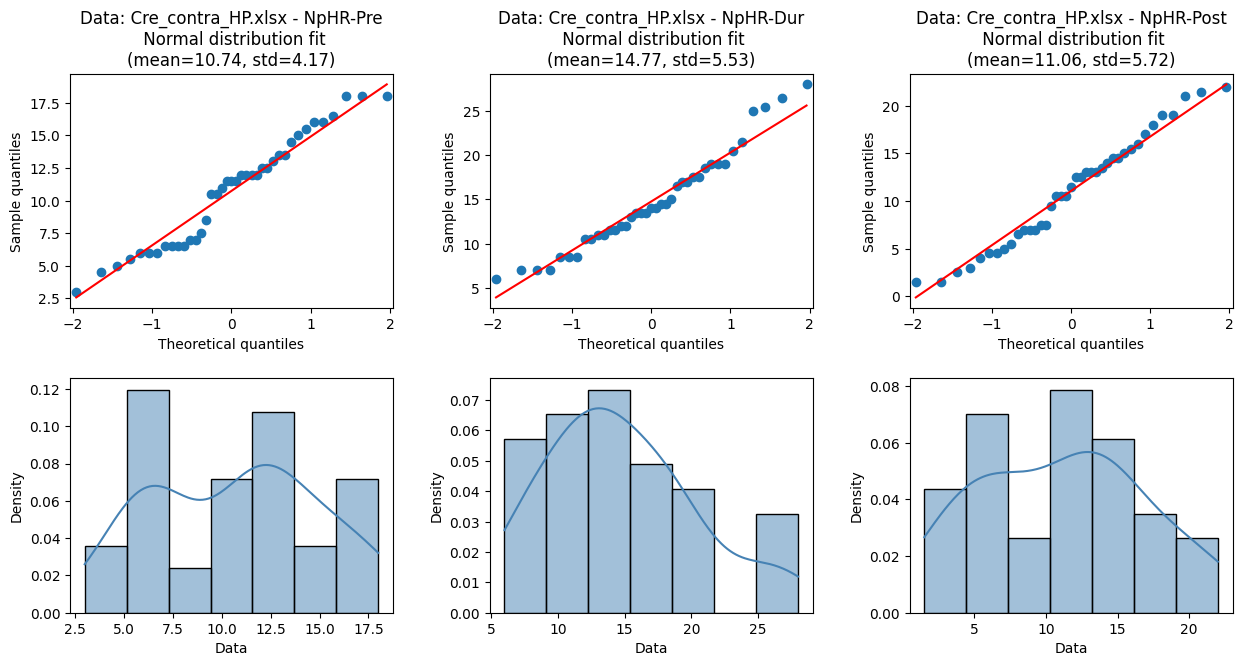


**********************************************************************************************************
Dataset: Cre_Ipsi_HP.xlsx;
 Do these groups have equal variances? True -- Statistic: 0.9174059290487505; P-value: 0.40248339006639255;
**********************************************************************************************************


Test  Normality Statistic  \
Cre_Ipsi_HP.xlsx NpHR-Pre  0      Shapiro Wilk      False     0.912   
                           1  Anderson Darling      False     1.133   
                           2        Lilliefors      False     0.157   
                 NpHR-Dur  0      Shapiro Wilk       True      0.97   
                           1  Anderson Darling       True     0.383   
                           2        Lilliefors       True     0.107   
                 NpHR-Post 0      Shapiro Wilk       True     0.972   
                           1  Anderson Darling       True     0.273   
                           2        Lilliefors       True     0.076   

                              P-value/critical  
Cre_Ipsi_HP.xlsx NpHR-Pre  0             0.005  
                           1             0.725  
                           2             0.018  
                 NpHR-Dur  0             0.381  
                           1             0.725  
                           2             0.314  
                 NpHR-Post 0             0.427  
                           1             0.725  
                           2             0.825

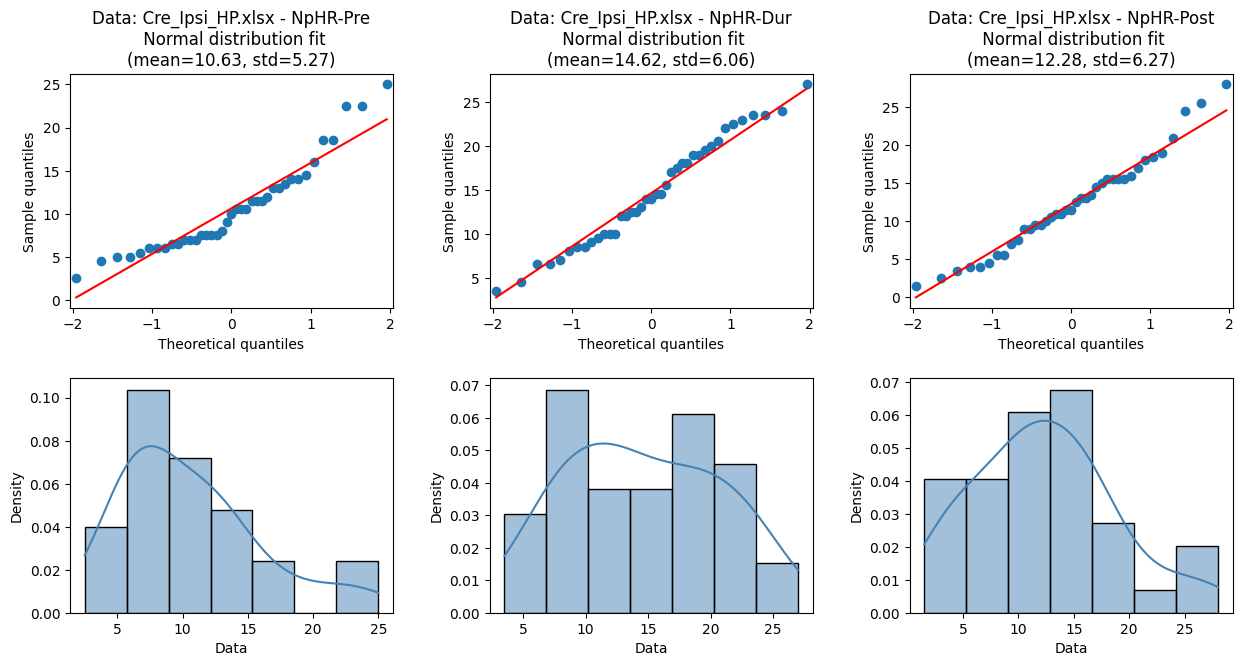


**********************************************************************************************************
Dataset: Cre_contra_VF.xlsx;
 Do these groups have equal variances? True -- Statistic: 0.05446831282012084; P-value: 0.9470131453458616;
**********************************************************************************************************


Test  Normality Statistic  \
Cre_contra_VF.xlsx NpHR-Pre  0      Shapiro Wilk      False     0.762   
                             1  Anderson Darling      False     3.821   
                             2        Lilliefors      False      0.26   
                   NpHR-Dur  0      Shapiro Wilk      False     0.755   
                             1  Anderson Darling      False      3.89   
                             2        Lilliefors      False     0.271   
                   NpHR-Post 0      Shapiro Wilk      False     0.763   
                             1  Anderson Darling      False     3.855   
                             2        Lilliefors      False     0.271   

                                P-value/critical  
Cre_contra_VF.xlsx NpHR-Pre  0             0.000  
                             1             0.725  
                             2             0.001  
                   NpHR-Dur  0             0.000  
                             1             0.725  
                             2             0.001  
                   NpHR-Post 0             0.000  
                             1             0.725  
                             2             0.001

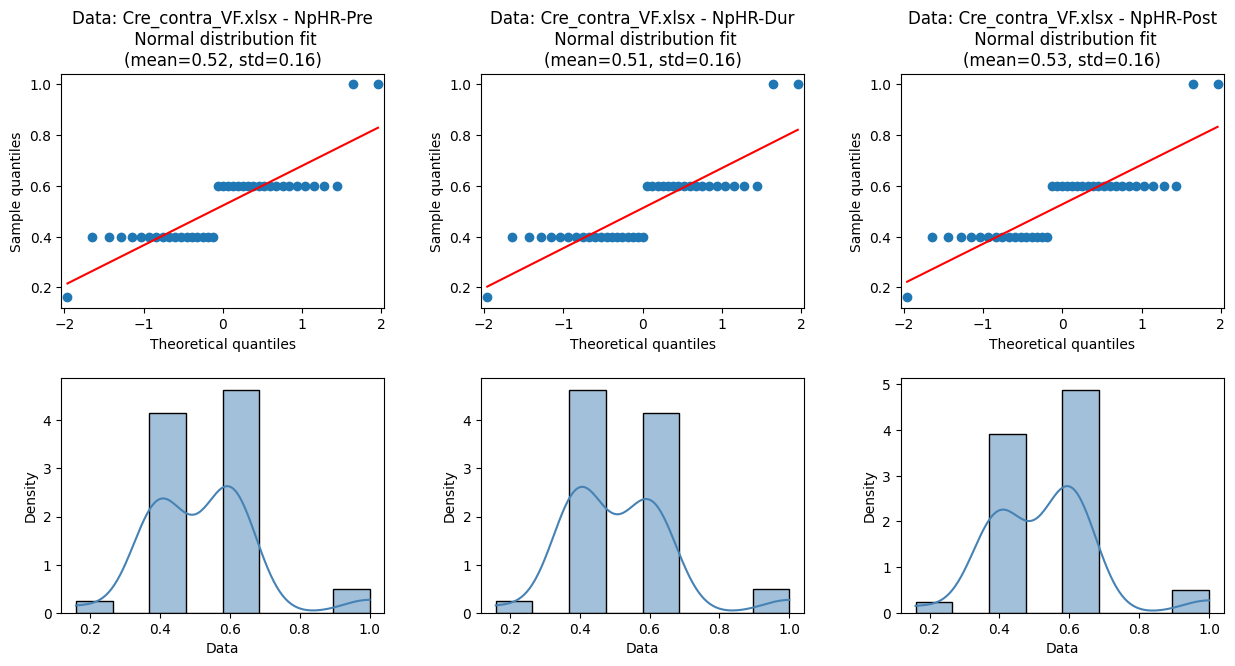


**********************************************************************************************************
Dataset: Cre_Ipsi_VF.xlsx;
 Do these groups have equal variances? True -- Statistic: 0.21296854284681221; P-value: 0.8085023648864647;
**********************************************************************************************************


Test  Normality Statistic  \
Cre_Ipsi_VF.xlsx NpHR-Pre  0      Shapiro Wilk      False     0.669   
                           1  Anderson Darling      False     4.396   
                           2        Lilliefors      False     0.274   
                 NpHR-Dur  0      Shapiro Wilk      False     0.637   
                           1  Anderson Darling      False     5.121   
                           2        Lilliefors      False     0.354   
                 NpHR-Post 0      Shapiro Wilk      False     0.642   
                           1  Anderson Darling      False     4.722   
                           2        Lilliefors      False     0.275   

                              P-value/critical  
Cre_Ipsi_VF.xlsx NpHR-Pre  0             0.000  
                           1             0.725  
                           2             0.001  
                 NpHR-Dur  0             0.000  
                           1             0.725  
                           2             0.001  
                 NpHR-Post 0             0.000  
                           1             0.725  
                           2             0.001

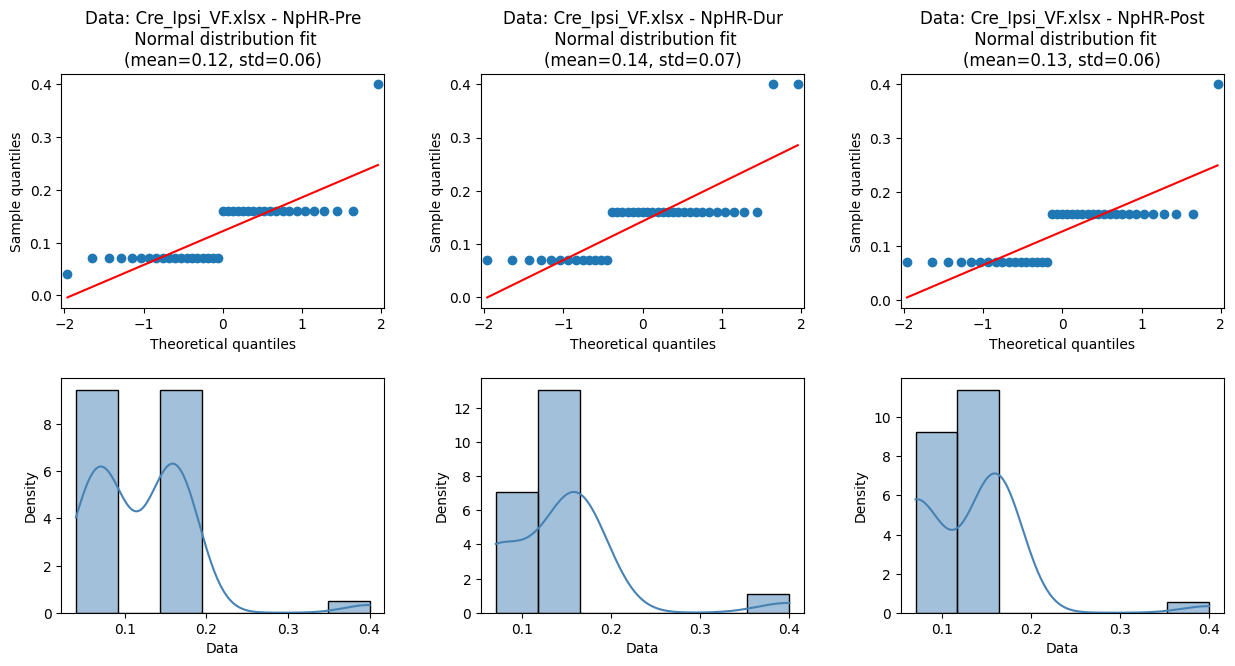


**********************************************************************************************************
Dataset: NpHR_contra_HP.xlsx;
 Do these groups have equal variances? True -- Statistic: 0.3625638342458544; P-value: 0.6963579985056767;
**********************************************************************************************************


Test  Normality Statistic  \
NpHR_contra_HP.xlsx NpHR-Pre  0      Shapiro Wilk       True     0.976   
                              1  Anderson Darling       True     0.366   
                              2        Lilliefors       True     0.068   
                    NpHR-Dur  0      Shapiro Wilk       True     0.985   
                              1  Anderson Darling       True     0.241   
                              2        Lilliefors       True     0.092   
                    NpHR-Post 0      Shapiro Wilk      False     0.936   
                              1  Anderson Darling      False     1.455   
                              2        Lilliefors      False     0.142   

                                 P-value/critical  
NpHR_contra_HP.xlsx NpHR-Pre  0             0.222  
                              1             0.746  
                              2             0.693  
                    NpHR-Dur  0             0.600  
                              1             0.746  
                              2             0.228  
                    NpHR-Post 0             0.002  
                              1             0.746  
                              2             0.004

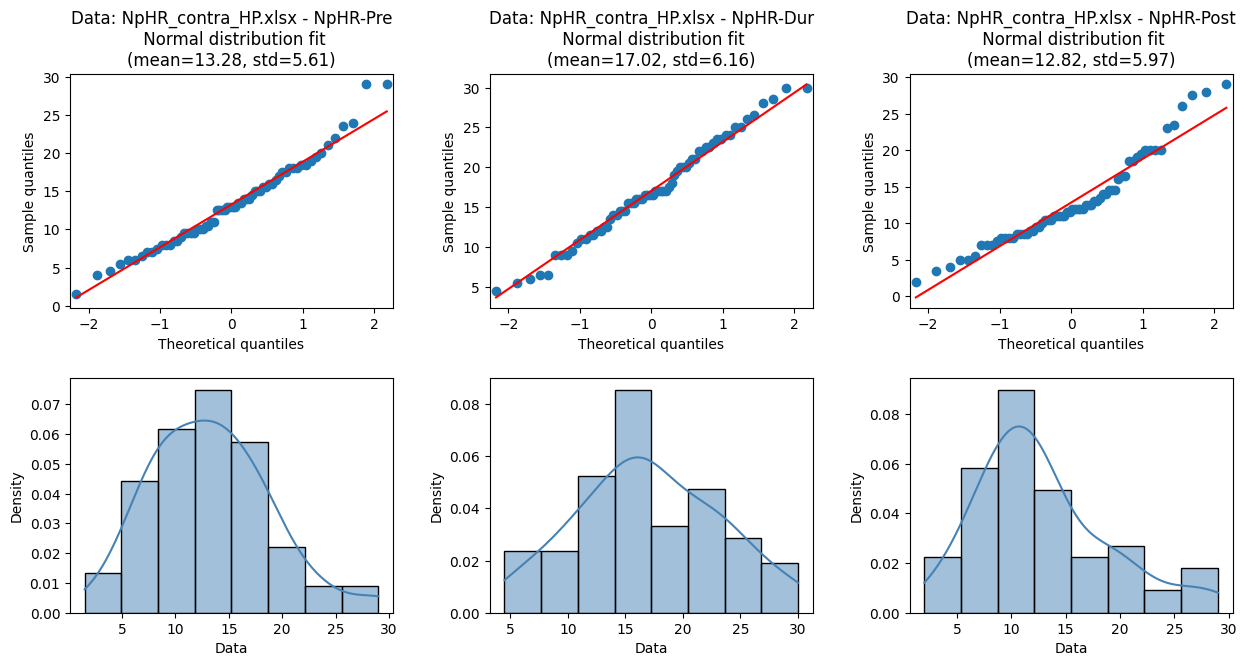


**********************************************************************************************************
Dataset: NpHR_contra_VF.xlsx;
 Do these groups have equal variances? True -- Statistic: 1.6098135795018957; P-value: 0.2025702917132456;
**********************************************************************************************************


Test  Normality Statistic  \
NpHR_contra_VF.xlsx NpHR-Pre  0      Shapiro Wilk      False     0.765   
                              1  Anderson Darling      False     6.269   
                              2        Lilliefors      False     0.255   
                    NpHR-Dur  0      Shapiro Wilk      False     0.767   
                              1  Anderson Darling      False     6.842   
                              2        Lilliefors      False     0.307   
                    NpHR-Post 0      Shapiro Wilk      False     0.657   
                              1  Anderson Darling      False     9.395   
                              2        Lilliefors      False     0.349   

                                 P-value/critical  
NpHR_contra_VF.xlsx NpHR-Pre  0             0.000  
                              1             0.746  
                              2             0.001  
                    NpHR-Dur  0             0.000  
                              1             0.746  
                              2             0.001  
                    NpHR-Post 0             0.000  
                              1             0.746  
                              2             0.001

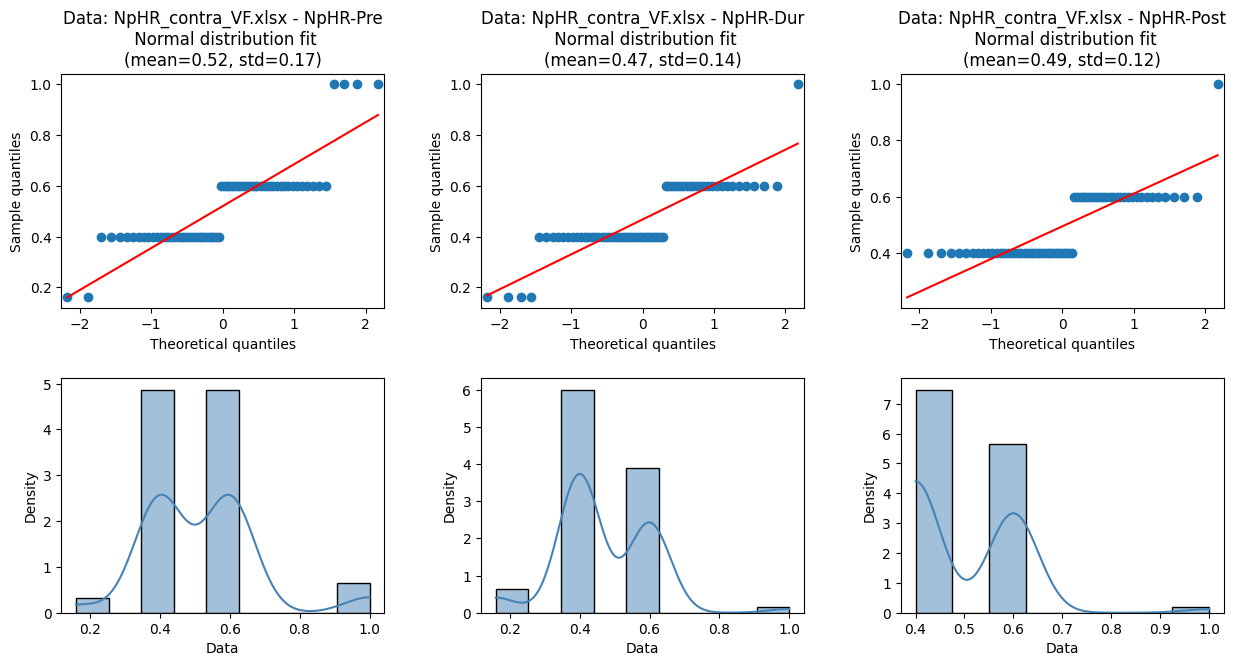


**********************************************************************************************************
Dataset: NpHR_Ipsi_HP.xlsx;
 Do these groups have equal variances? True -- Statistic: 1.0096805521654009; P-value: 0.3662319534960134;
**********************************************************************************************************


Test  Normality Statistic  \
NpHR_Ipsi_HP.xlsx NpHR-Pre  0      Shapiro Wilk      False     0.962   
                            1  Anderson Darling       True     0.729   
                            2        Lilliefors      False     0.114   
                  NpHR-Dur  0      Shapiro Wilk      False     0.954   
                            1  Anderson Darling      False     0.895   
                            2        Lilliefors       True     0.101   
                  NpHR-Post 0      Shapiro Wilk       True     0.983   
                            1  Anderson Darling       True      0.28   
                            2        Lilliefors       True     0.063   

                               P-value/critical  
NpHR_Ipsi_HP.xlsx NpHR-Pre  0             0.044  
                            1             0.746  
                            2             0.047  
                  NpHR-Dur  0             0.016  
                            1             0.746  
                            2             0.126  
                  NpHR-Post 0             0.484  
                            1             0.746  
                            2             0.792

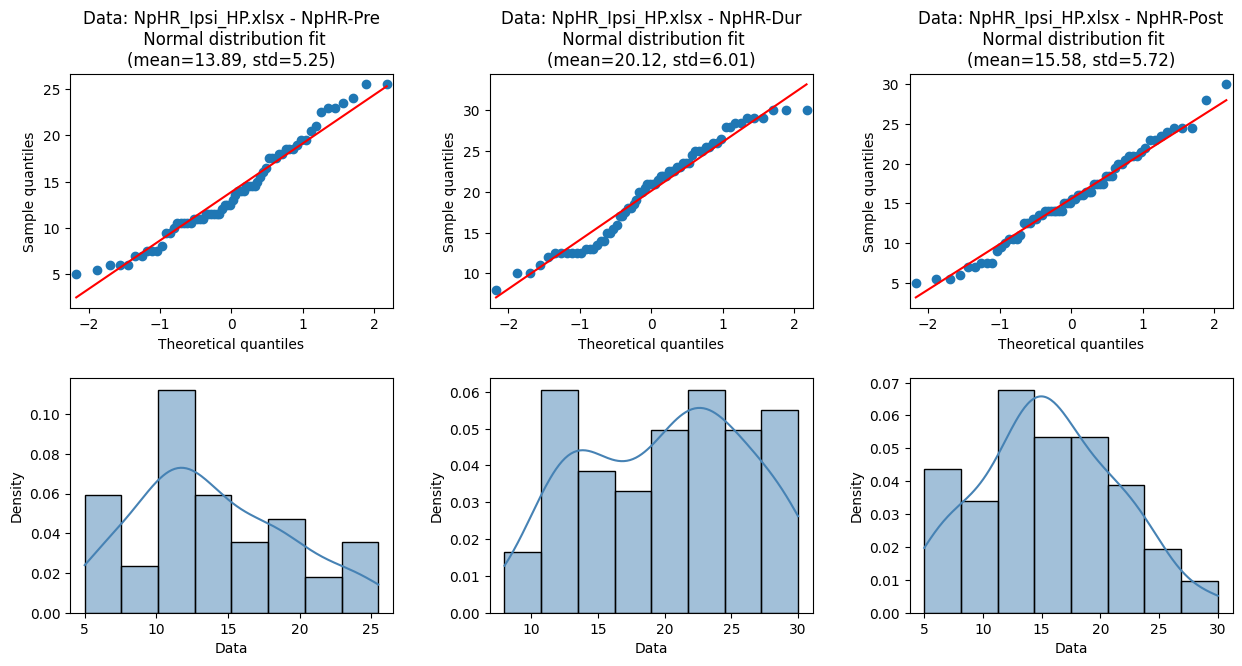


**********************************************************************************************************
Dataset: NpHR_Ipsi_VF.xlsx;
 Do these groups have equal variances? False -- Statistic: 18.83970244443222; P-value: 3.307310982615666e-08;
**********************************************************************************************************


Test  Normality Statistic  \
NpHR_Ipsi_VF.xlsx NpHR-Pre  0      Shapiro Wilk      False     0.658   
                            1  Anderson Darling      False     8.182   
                            2        Lilliefors      False     0.307   
                  NpHR-Dur  0      Shapiro Wilk      False     0.783   
                            1  Anderson Darling      False     6.736   
                            2        Lilliefors      False     0.356   
                  NpHR-Post 0      Shapiro Wilk      False     0.635   
                            1  Anderson Darling      False     11.75   
                            2        Lilliefors      False     0.355   

                               P-value/critical  
NpHR_Ipsi_VF.xlsx NpHR-Pre  0             0.000  
                            1             0.746  
                            2             0.001  
                  NpHR-Dur  0             0.000  
                            1             0.746  
                            2             0.001  
                  NpHR-Post 0             0.000  
                            1             0.746  
                            2             0.001

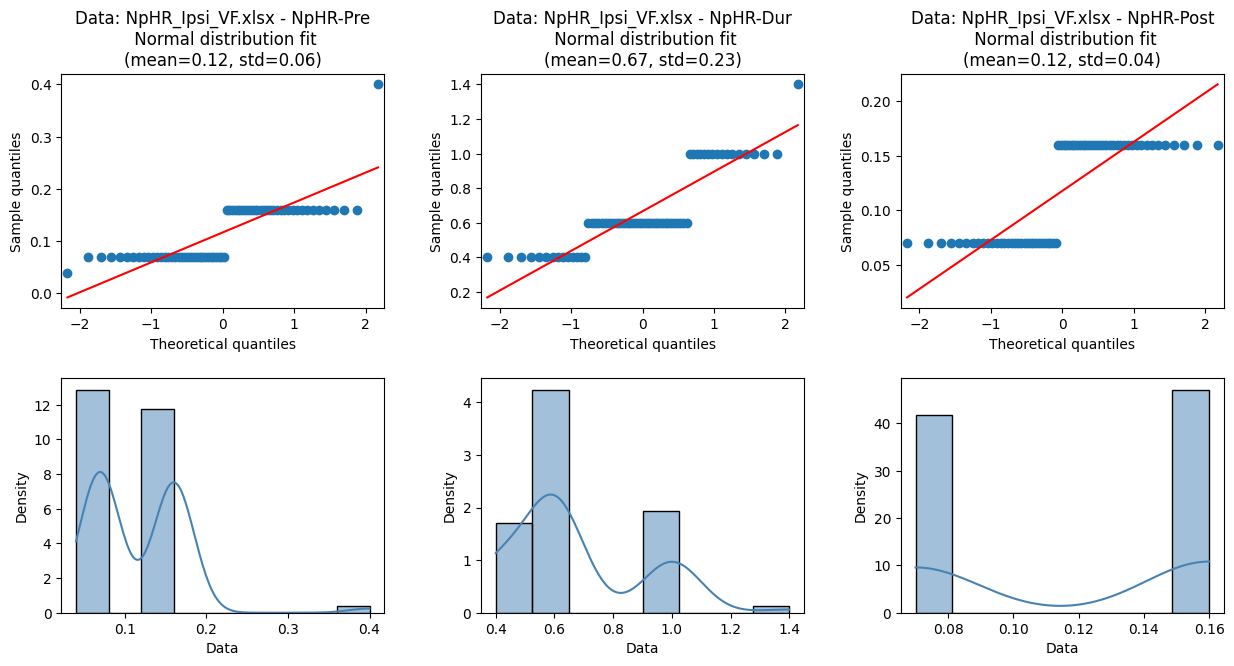


**********************************************************************************************************
Dataset: ChR2_EMG.xlsx;
 Do these groups have equal variances? False -- Statistic: 38.69129803975221; P-value: 1.0047003485484104e-08;
**********************************************************************************************************


Test  Normality Statistic  \
ChR2_EMG.xlsx Not activated 0      Shapiro Wilk       True     0.976   
                            1  Anderson Darling       True     0.416   
                            2        Lilliefors       True      0.09   
              Activated     0      Shapiro Wilk      False      0.92   
                            1  Anderson Darling      False     1.621   
                            2        Lilliefors      False     0.145   

                               P-value/critical  
ChR2_EMG.xlsx Not activated 0             0.345  
                            1             0.739  
                            2             0.357  
              Activated     0             0.002  
                            1             0.739  
                            2             0.008

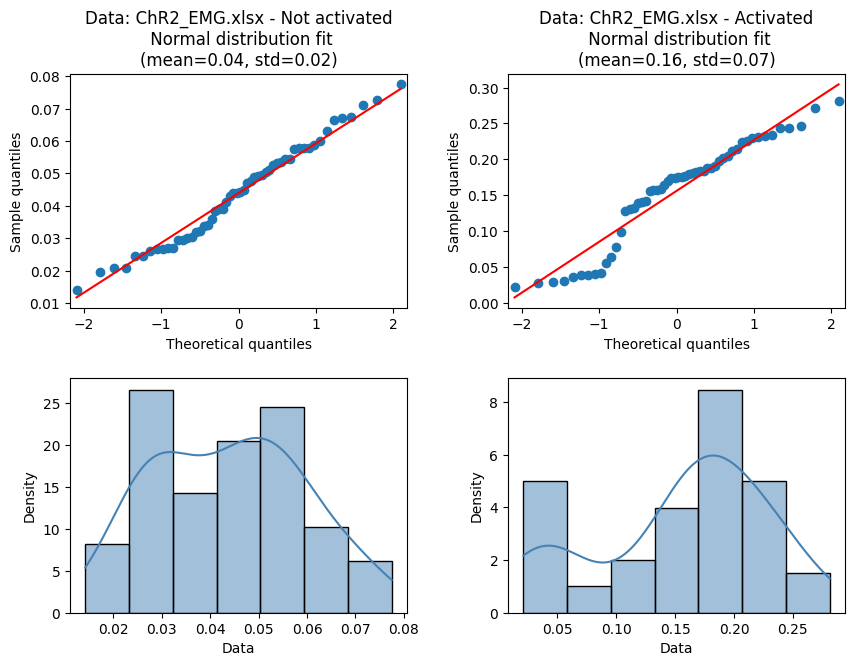

In [ ]:
dataset_normality_analysis()